## BTC Asset Metrics

1. **AdrActCnt**: The number of unique addresses that were active in the network either as a sender or receiver of a transaction.
2. **AdrBal1in100KCnt**: The count of unique addresses holding a balance that ranks them in the top 100,000 addresses.
3. **AdrBal1in100MCnt**: The count of unique addresses holding a balance that ranks them in the top 100 million addresses.
4. **AdrBal1in10BCnt**: The count of unique addresses holding a balance that ranks them in the top 10 billion addresses.
5. **AdrBal1in10KCnt**: The count of unique addresses holding a balance that ranks them in the top 10,000 addresses.
6. **AdrBal1in10MCnt**: The count of unique addresses holding a balance that ranks them in the top 10 million addresses.
7. **AdrBal1in1BCnt**: The count of unique addresses holding a balance that ranks them in the top 1 billion addresses.
8. **AdrBal1in1KCnt**: The count of unique addresses holding a balance that ranks them in the top 1,000 addresses.
9. **AdrBal1in1MCnt**: The count of unique addresses holding a balance that ranks them in the top 1 million addresses.
10. **AdrBalCnt**: The total number of unique addresses that have a balance greater than zero.
11. **AdrBalNtv0.001Cnt**: The count of addresses with a native currency balance of at least 0.001.
12. **AdrBalNtv0.01Cnt**: The count of addresses with a native currency balance of at least 0.01.
13. **AdrBalNtv0.1Cnt**: The count of addresses with a native currency balance of at least 0.1.
14. **AdrBalNtv100Cnt**: The count of addresses with a native currency balance of at least 100.
15. **AdrBalNtv100KCnt**: The count of addresses with a native currency balance of at least 100,000.
16. **AdrBalNtv10Cnt**: The count of addresses with a native currency balance of at least 10.
17. **AdrBalNtv10KCnt**: The count of addresses with a native currency balance of at least 10,000.
18. **AdrBalNtv1Cnt**: The count of addresses with a native currency balance of at least 1.
19. **AdrBalNtv1KCnt**: The count of addresses with a native currency balance of at least 1,000.
20. **AdrBalNtv1MCnt**: The count of addresses with a native currency balance of at least 1 million.
21. **AdrBalUSD100Cnt**: The count of addresses with a balance worth at least 100 USD.
22. **AdrBalUSD100KCnt**: The count of addresses with a balance worth at least 100,000 USD.
23. **AdrBalUSD10Cnt**: The count of addresses with a balance worth at least 10 USD.
24. **AdrBalUSD10KCnt**: The count of addresses with a balance worth at least 10,000 USD.
25. **AdrBalUSD10MCnt**: The count of addresses with a balance worth at least 10 million USD.
26. **AdrBalUSD1Cnt**: The count of addresses with a balance worth at least 1 USD.
27. **AdrBalUSD1KCnt**: The count of addresses with a balance worth at least 1,000 USD.
28. **AdrBalUSD1MCnt**: The count of addresses with a balance worth at least 1 million USD.
29. **AssetEODCompletionTime**: The time at which the end-of-day (EOD) asset data processing was completed.
30. **BlkCnt**: The total number of blocks created on a given day.
31. **BlkSizeMeanByte**: The average size of blocks (in bytes) created on a given day.
32. **BlkWghtMean**: The average weight of blocks created on a given day.
33. **BlkWghtTot**: The total weight of all blocks created on a given day.
34. **CapAct1yrUSD**: The market capitalization based on the last active supply one year ago, in USD.
35. **CapMVRVCur**: The ratio of the current market capitalization to the realized capitalization.
36. **CapMVRVFF**: The ratio of free-float market capitalization to the free-float realized capitalization.
37. **CapMrktCurUSD**: The current market capitalization in USD.
38. **CapMrktEstUSD**: The estimated market capitalization in USD, considering coins that might be lost.
39. **CapMrktFFUSD**: The free-float market capitalization in USD.
40. **CapRealUSD**: The realized capitalization, a measure of the value paid for coins in USD.
41. **DiffLast**: The latest difficulty level for mining.
42. **DiffMean**: The average difficulty level for mining over a specific period.
43. **FeeByteMeanNtv**: The average fee per byte (in native currency) for transactions.
44. **FeeMeanNtv**: The average transaction fee (in native currency).
45. **FeeMeanUSD**: The average transaction fee in USD.
46. **FeeMedNtv**: The median transaction fee (in native currency).
47. **FeeMedUSD**: The median transaction fee in USD.
48. **FeeTotNtv**: The total transaction fees (in native currency) for a specific period.
49. **FeeTotUSD**: The total transaction fees in USD for a specific period.
50. **FlowInExNtv**: The total native currency amount flowing into exchanges.
51. **FlowInExUSD**: The total USD value of native currency flowing into exchanges.
52. **FlowOutExNtv**: The total native currency amount flowing out of exchanges.
53. **FlowOutExUSD**: The total USD value of native currency flowing out of exchanges.
54. **FlowTfrFromExCnt**: The count of transfers from exchange addresses.
55. **HashRate**: The total computational power used to process transactions and mine new blocks.
56. **HashRate30d**: The average hash rate over the past 30 days.
57. **IssContNtv**: The amount of new native currency issued on a continuous basis.
58. **IssContPctAnn**: The annualized percentage rate of new currency issuance.
59. **IssContPctDay**: The daily percentage rate of new currency issuance.
60. **IssContUSD**: The USD value of new currency issued on a continuous basis.
61. **IssTotNtv**: The total amount of native currency issued since inception.
62. **IssTotUSD**: The total USD value of all native currency issued since inception.
63. **NDF**: The Net Unrealized Profit/Loss (NUPL) divided by the market cap, providing an understanding of market sentiment.
64. **NVTAdj**: The Network Value to Transactions ratio, adjusted for the change in native currency supply.
65. **NVTAdj90**: The 90-day moving average of the adjusted Network Value to Transactions ratio.
66. **NVTAdjFF**: The free-float adjusted Network Value to Transactions ratio.
67. **NVTAdjFF90**: The 90-day moving average of the free-float adjusted Network Value to Transactions ratio.
68. **PriceBTC**: The price of the asset in terms of Bitcoin.
69. **PriceUSD**: The price of the asset in USD.
70. **ROI1yr**: The return on investment over the past year.
71. **ROI30d**: The return on investment over the past 30 days.
72. **ReferenceRate**: The reference interest rate for the asset.
73. **ReferenceRateETH**: The Ethereum-based reference rate for the asset.
74. **ReferenceRateEUR**: The Euro-based reference rate for the asset.
75. **ReferenceRateUSD**: The USD-based reference rate for the asset.
76. **RevAllTimeUSD**: The total revenue generated by the asset in USD since its inception.
77. **RevHashNtv**: The native currency revenue per hash.
78. **RevHashRateNtv**: The native currency revenue per unit of hash rate.
79. **RevHashRateUSD**: The USD revenue per unit of hash rate.
80. **RevHashUSD**: The USD revenue per hash.
81. **RevNtv**: The total native currency revenue generated.
82. **RevUSD**: The total revenue generated in USD.
83. **SER**: The Supply Elasticity Ratio, measuring the responsiveness of new supply issuance to price changes.
84. **SplyAct10yr**: The active supply within the last 10 years.
85. **SplyAct180d**: The active supply within the last 180 days.
86. **SplyAct1d**: The active supply within the last day.
87. **SplyAct1yr**: The active supply within the last year.
88. **SplyAct2yr**: The active supply within the last 2 years.
89. **SplyAct30d**: The active supply within the last 30 days.
90. **SplyAct3yr**: The active supply within the last 3 years.
91. **SplyAct4yr**: The active supply within the last 4 years.
92. **SplyAct5yr**: The active supply within the last 5 years.
93. **SplyAct7d**: The active supply within the last 7 days.
94. **SplyAct90d**: The active supply within the last 90 days.
95. **SplyActEver**: The total active supply since the asset's inception.
96. **SplyActPct1yr**: The percentage of the total supply that was active in the last year.
97. **SplyAdrBal1in100K**: The amount of supply held by the top 100,000 addresses.
98. **SplyAdrBal1in100M**: The amount of supply held by the top 100 million addresses.
99. **SplyAdrBal1in10B**: The amount of supply held by the top 10 billion addresses.
100. **SplyAdrBal1in10K**: The amount of supply held by the top 10,000 addresses.
101. **SplyAdrBal1in10M**: The amount of supply held by the top 10 million addresses.
102. **SplyAdrBal1in1B**: The amount of supply held by the top 1 billion addresses.
103. **SplyAdrBal1in1K**: The amount of supply held by the top 1,000 addresses.
104. **SplyAdrBal1in1M**: The amount of supply held by the top 1 million addresses.
105. **SplyAdrBalNtv0.001**: The amount of native currency supply held in addresses with at least 0.001 of the currency.
106. **SplyAdrBalNtv0.01**: The amount of native currency supply held in addresses with at least 0.01 of the currency.
107. **SplyAdrBalNtv0.1**: The amount of native currency supply held in addresses with at least 0.1 of the currency.
108. **SplyAdrBalNtv1**: The amount of native currency supply held in addresses with at least 1 of the currency.
109. **SplyAdrBalNtv10**: The amount of native currency supply held in addresses with at least 10 of the currency.
110. **SplyAdrBalNtv100**: The amount of native currency supply held in addresses with at least 100 of the currency.
111. **SplyAdrBalNtv100K**: The amount of native currency supply held in addresses with at least 100,000 of the currency.
112. **SplyAdrBalNtv10K**: The amount of native currency supply held in addresses with at least 10,000 of the currency.
113. **SplyAdrBalNtv1K**: The amount of native currency supply held in addresses with at least 1,000 of the currency.
114. **SplyAdrBalNtv1M**: The amount of native currency supply held in addresses with at least 1 million of the currency.
115. **SplyAdrBalUSD1**: The amount of USD supply held in addresses with at least 1 USD worth of the currency.
116. **SplyAdrBalUSD10**: The amount of USD supply held in addresses with at least 10 USD worth of the currency.
117. **SplyAdrBalUSD100**: The amount of USD supply held in addresses with at least 100 USD worth of the currency.
118. **SplyAdrBalUSD100K**: The amount of USD supply held in addresses with at least 100,000 USD worth of the currency.
119. **SplyAdrBalUSD10K**: The amount of USD supply held in addresses with at least 10,000 USD worth of the currency.
120. **SplyAdrBalUSD10M**: The amount of USD supply held in addresses with at least 10 million USD worth of the currency.
121. **SplyAdrBalUSD1K**: The amount of USD supply held in addresses with at least 1,000 USD worth of the currency.
122. **SplyAdrBalUSD1M**: The amount of USD supply held in addresses with at least 1 million USD worth of the currency.
123. **SplyAdrTop100**: The total supply held by the top 100 addresses.
124. **SplyAdrTop10Pct**: The total supply held by the top 10% of addresses.
125. **SplyAdrTop1Pct**: The total supply held by the top 1% of addresses.
126. **SplyCur**: The current total supply of the asset.
127. **SplyExpFut10yr**: The expected future supply of the asset in 10 years.
128. **SplyFF**: The free-float supply, or the amount of supply not known to be lost or held in long-term storage.
135. **TxCnt**: The total number of transactions that occurred on the network for a given time period.
136. **TxCntSec**: The number of transactions per second on the network, indicating the throughput of transactions.
137. **TxTfrCnt**: The count of transfer transactions, specifically those moving assets between addresses, in a given time frame.
138. **TxTfrValAdjNtv**: The total value of native currency transferred between addresses, adjusted to exclude certain types of transactions like self-transfers and coinbase transactions.
139. **TxTfrValAdjUSD**: The total USD value of native currency transferred between addresses, adjusted to exclude certain types of transactions like self-transfers and coinbase transactions.
140. **TxTfrValMeanNtv**: The average value of native currency transferred per transaction, indicating the typical transaction size.
141. **TxTfrValMeanUSD**: The average USD value of native currency transferred per transaction.
142. **TxTfrValMedNtv**: The median value of native currency transferred per transaction, providing a more typical transaction size that is less affected by very large or small transfers.
143. **TxTfrValMedUSD**: The median USD value of native currency transferred per transaction.
144. **VelCur1yr**: The velocity of the currency over one year, measuring the frequency at which the average unit of currency is used for transactions.
145. **VtyDayRet180d**: The volatility of daily returns over the past 180 days, indicating the level of price fluctuation and risk.
146. **VtyDayRet30d**: The volatility of daily returns over the past 30 days, providing a short-term measure of price fluctuation and risk.

## Load libraries

In [1]:
# Imports
import numpy as np
from numpy import genfromtxt
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import os
%matplotlib inline
import multiprocessing

import sklearn
import dcor

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
import tigramite.independence_tests 

from tigramite.toymodels import structural_causal_processes as toys

## Data processing

In [2]:
df = pd.read_parquet("amalgamated.parquet")

In [3]:
df.columns

Index(['AdrActCnt', 'AdrBal1in100KCnt', 'AdrBal1in100MCnt', 'AdrBal1in10BCnt',
       'AdrBal1in10KCnt', 'AdrBal1in10MCnt', 'AdrBal1in1BCnt',
       'AdrBal1in1KCnt', 'AdrBal1in1MCnt', 'AdrBalCnt',
       ...
       'TxTfrValMedNtv', 'TxTfrValMedUSD', 'VelCur1yr', 'VtyDayRet180d',
       'VtyDayRet30d', '^IRX', '^TNX', '^TYX', 'SPY', 'QQQ'],
      dtype='object', length=147)

In [4]:
#df = df.drop(columns=['time']).reset_index(drop=True)

In [5]:
df.shape

(2019, 147)

In [6]:
df = df.tail(520)

In [7]:
df = df.reset_index(drop=True)

In [8]:
metrics = [
    "ReferenceRateUSD",
    "AdrBalNtv0.01Cnt",
    "AdrBalNtv0.1Cnt",
    "AdrBalNtv1Cnt",
    "BlkSizeMeanByte",
    "FeeByteMeanNtv",
    "FlowInExNtv",
    "FlowOutExNtv",
    "HashRate",
    "SplyAct1d",
    "TxCnt",
    "^IRX",
    "^TNX",
    "^TYX",
    "SPY",
    "QQQ"
]

In [9]:
df = df[metrics]
df

,ReferenceRateUSD,AdrBalNtv0.01Cnt,AdrBalNtv0.1Cnt,AdrBalNtv1Cnt,BlkSizeMeanByte,FeeByteMeanNtv,FlowInExNtv,FlowOutExNtv,HashRate,SplyAct1d,TxCnt,^IRX,^TNX,^TYX,SPY,QQQ
0,57920.710730,9365681,3295039,814013,1.251679e+06,7.977200e-08,25085.856613,13327.211196,1.487818e+08,445688.875310,296340,0.048,1.443,1.787,455.559998,393.820007
1,57097.012794,9345860,3290397,813347,1.407985e+06,1.052310e-07,24631.778417,40307.852238,1.521127e+08,458807.583587,284941,0.050,1.434,1.778,450.500000,387.119995
2,57180.609844,9308992,3279907,811071,1.503257e+06,7.987600e-08,25678.297986,49000.165568,1.720983e+08,506704.676264,315565,0.043,1.448,1.769,457.399994,389.910004
3,56582.893769,9315551,3279730,811661,1.083237e+06,7.356300e-08,24942.300919,15249.429953,1.865324e+08,467346.649149,289452,0.043,1.343,1.678,453.420013,383.130005
4,49327.093600,9351355,3291529,813636,1.103169e+06,7.020700e-08,41372.253494,52512.718556,1.909736e+08,406418.555710,286268,0.043,1.434,1.757,458.790009,386.200012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,41428.665786,12681341,4575213,1022207,1.667253e+06,1.436019e-06,22990.830060,23236.925670,5.620935e+08,225164.595289,641771,5.225,3.954,4.069,471.970001,407.079987
516,42635.733191,12696275,4578699,1022751,1.695853e+06,1.550105e-06,19126.557035,18847.655666,5.420188e+08,291689.689496,662370,5.238,3.922,4.035,474.839996,409.160004
517,42271.863026,12711579,4580738,1022811,1.658518e+06,1.781574e-06,24243.262874,26274.302048,4.851402e+08,299585.040567,580281,5.230,3.877,4.005,468.260010,403.079987
518,43605.155555,12724066,4583262,1023340,1.708325e+06,1.627281e-06,20075.140452,20332.299706,4.884860e+08,298825.317741,589222,5.210,3.894,4.036,472.700012,407.769989


In [10]:
array = df.to_numpy()

In [11]:
from tigramite.independence_tests.parcorr_mult import ParCorrMult
from tigramite.independence_tests.cmiknn import CMIknn

var_names = metrics

parcorr = ParCorrMult()
cmi = CMIknn()

df_final = pp.DataFrame(array, var_names=var_names)

## LPCMCI

In [12]:
%%time

lpcmci_aug = LPCMCI(dataframe=df_final, 
                cond_ind_test=parcorr,
                verbosity=0)

# Define the analysis parameters
tau_max = 7
pc_alpha = 0.01
#max_cond_px = 2  # Example value, adjust based on your data
#max_p_global = 2 # Use the default unless computational time is a concern
#max_p_non_ancestral = 2 # Same as above
#max_q_global = 5  # Same as above
#max_pds_set = 5  # Same as above
#n_preliminary_iterations = 2  # Adjust as needed

# Run LPCMCI
result = lpcmci_aug.run_lpcmci(
    tau_max=tau_max,
    pc_alpha=pc_alpha
#    max_cond_px=max_cond_px,
#    max_p_global=max_p_global,
#    max_p_non_ancestral=max_p_non_ancestral,
#    max_q_global=max_q_global,
#    max_pds_set=max_pds_set,
#    n_preliminary_iterations=n_preliminary_iterations
)

CPU times: user 44.4 s, sys: 0 ns, total: 44.4 s
Wall time: 44.4 s


## Plotting

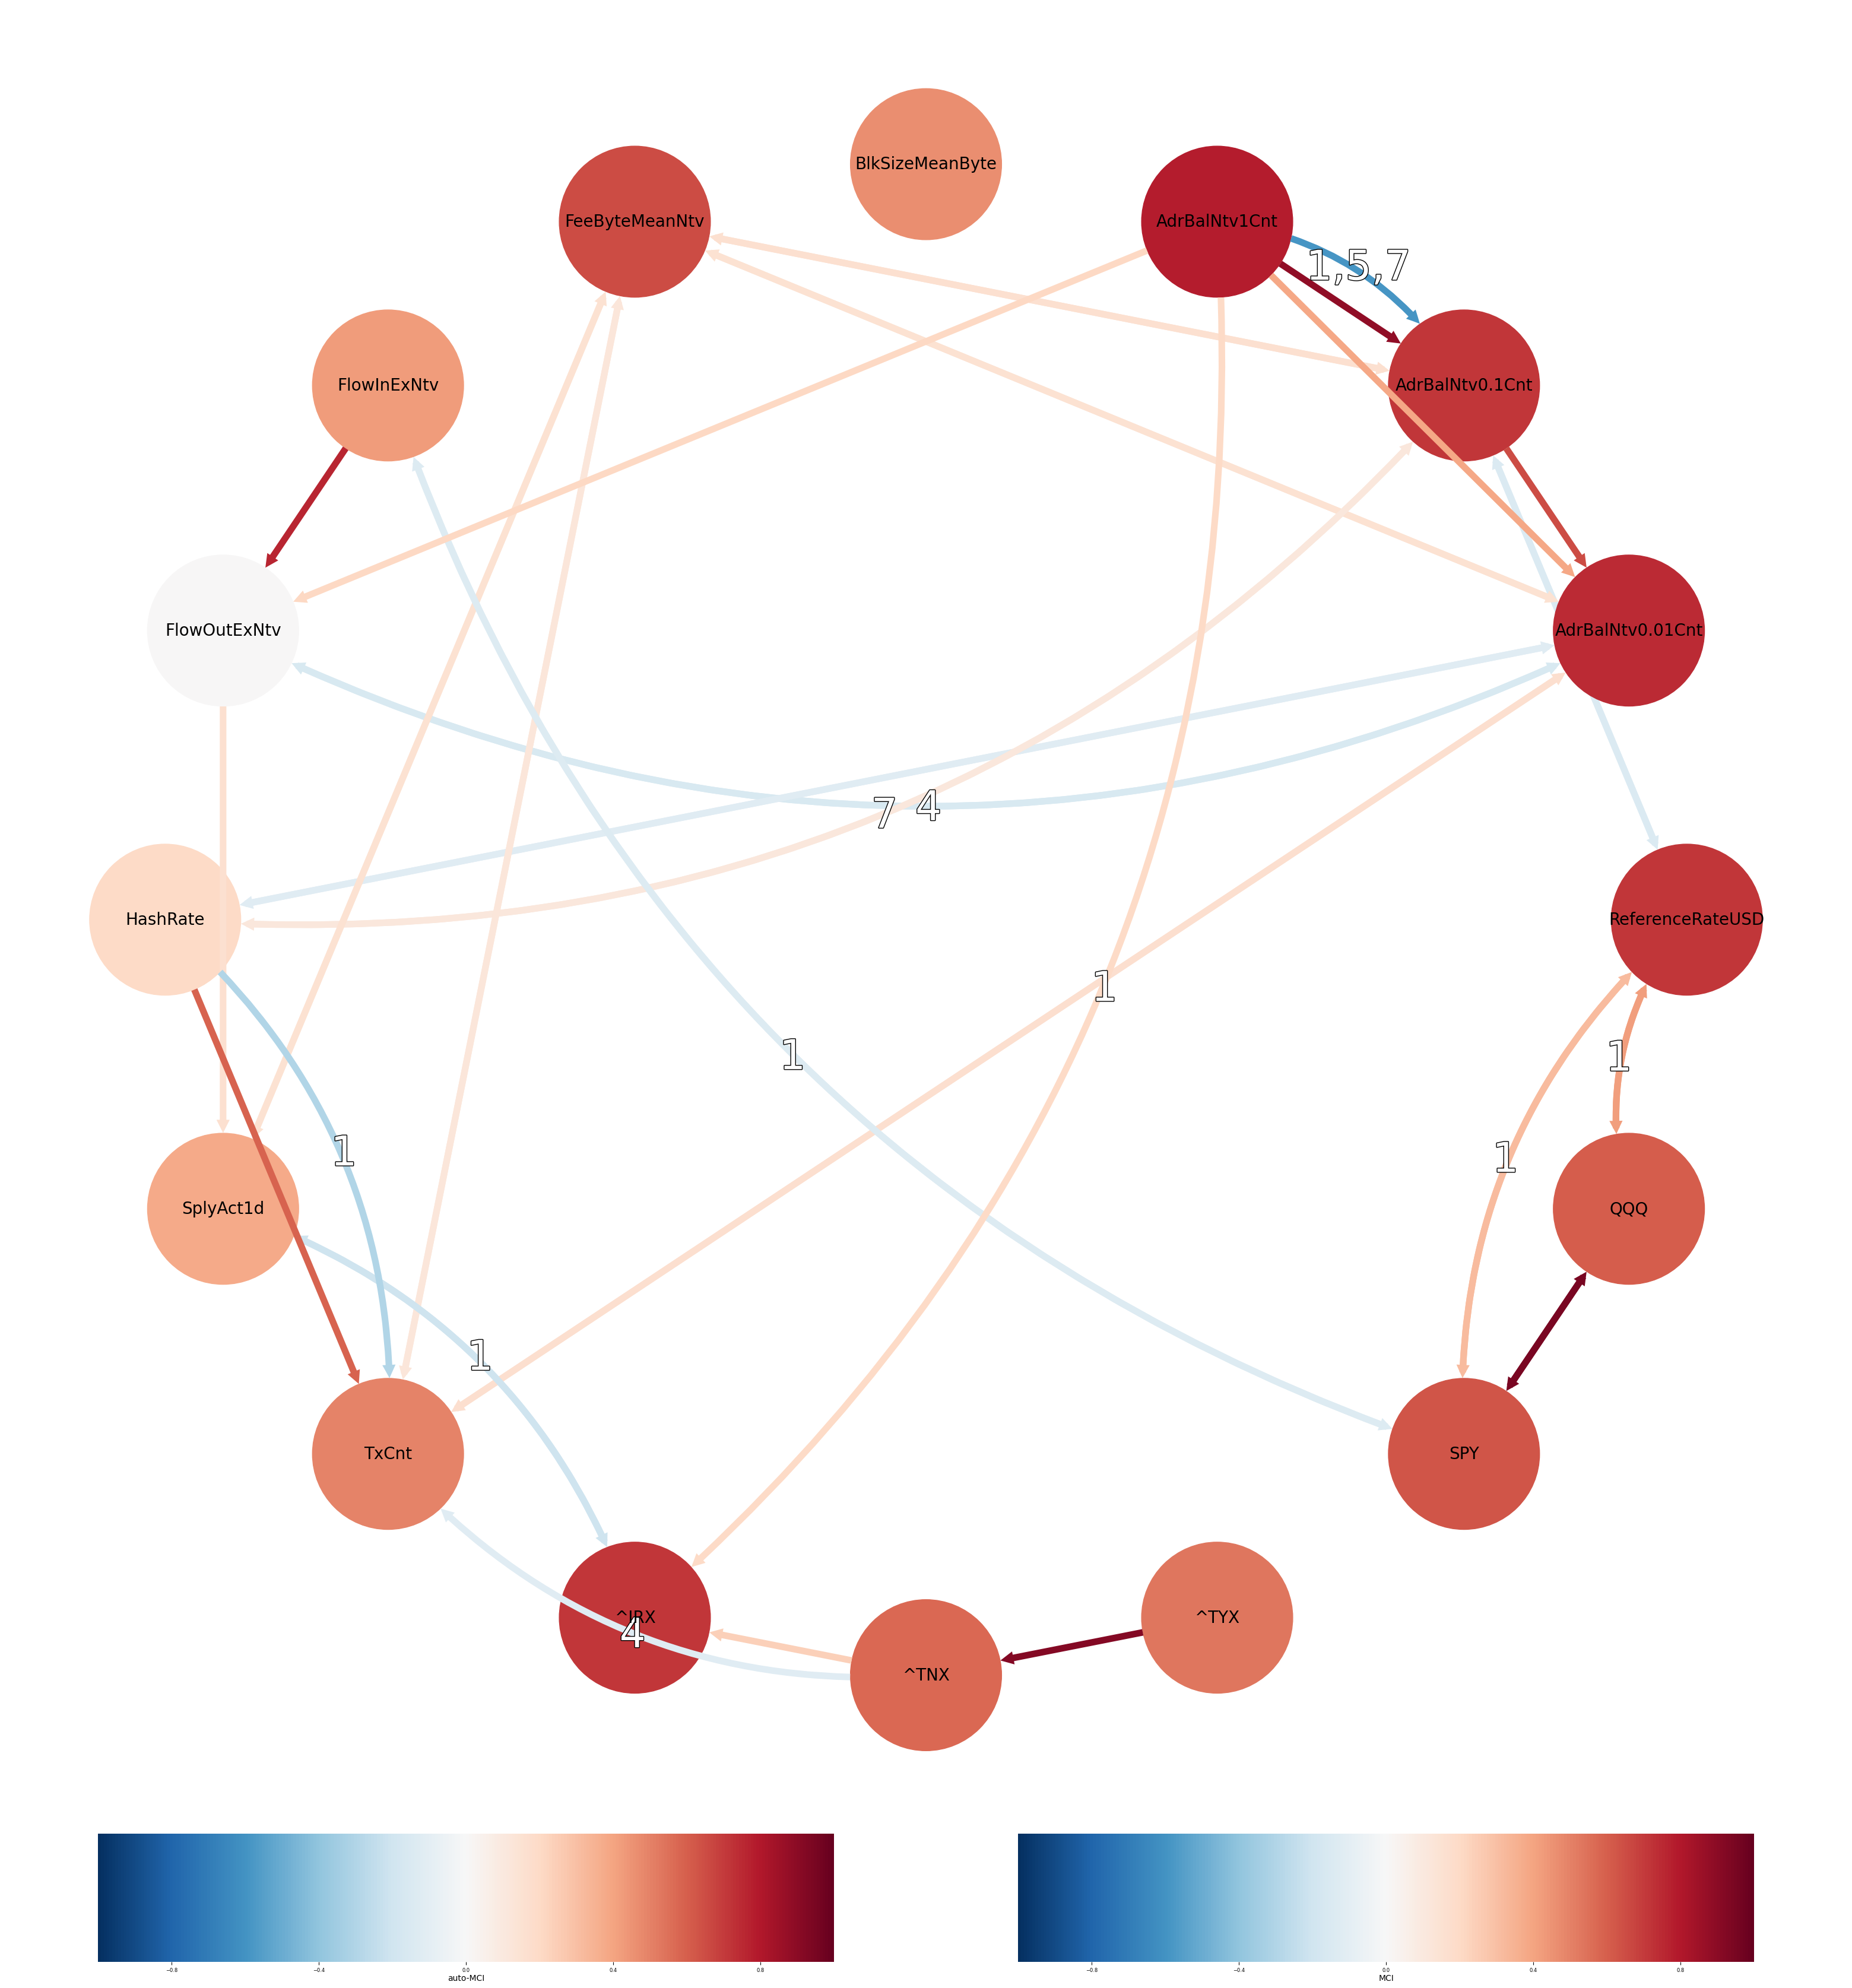

CPU times: user 3.23 s, sys: 833 ms, total: 4.06 s
Wall time: 3.11 s


In [13]:
%%time

tp.plot_graph(
    figsize=(40, 40),
    val_matrix=result['val_matrix'],
    graph=result['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_size=0.2,
    node_label_size = 20,
    link_label_fontsize = 50,
    curved_radius = 0.25
)

# Save the plot to an SVG file before showing it
plt.savefig('lpcmci_graph.jpg', format='jpg')

plt.show()

In [17]:
# Initialize a list to store the relation information
relation_info = []

# Iterate over the rows, columns, and tau of the graph matrix
for i, x_var in enumerate(var_names):
    for j, y_var in enumerate(var_names):
        for tau in range(result['graph'].shape[2]):
            relation = result['graph'][i, j, tau]

            # Check if the relation is not an empty string
            if relation:
                mci_val = result['val_matrix'][i, j]
                p_val = result['p_matrix'][i, j]

                # Check if mci_val and p_val are arrays and extract the first element
                if isinstance(mci_val, np.ndarray) and mci_val.size > 0:
                    mci_val = mci_val[0]
                if isinstance(p_val, np.ndarray) and p_val.size > 0:
                    p_val = p_val[0]

                # Append the relation information to the list only if abs(MCI) >= 0.001 and p-value < pc_alpha
                if mci_val is not None and p_val is not None and abs(mci_val) >= 0.001 and p_val < pc_alpha:
                    relation_info.append((x_var, y_var, tau, relation, mci_val, p_val))

# Sort the list by MCI value in descending order
relation_info.sort(key=lambda x: x[4], reverse=True)

# Print the sorted information
for x_var, y_var, tau, relation, mci_val, p_val in relation_info:
    print(f"Relation between '{x_var}' and '{y_var}' at lag {tau}:")
    print(f"  Type: {relation}")
    print(f"  MCI Value: {mci_val:.4f}")  # Adjust the number of decimal places as needed
    print(f"  P-Value: {p_val:.4g}")  # Adjust the number of decimal places as needed
    print("-" * 40)  # Separator for readability


Relation between 'SPY' and 'QQQ' at lag 0:
  Type: <->
  MCI Value: 0.9477
  P-Value: 1.481e-250
----------------------------------------
Relation between 'QQQ' and 'SPY' at lag 0:
  Type: <->
  MCI Value: 0.9477
  P-Value: 1.481e-250
----------------------------------------
Relation between '^TNX' and '^TYX' at lag 0:
  Type: <--
  MCI Value: 0.9203
  P-Value: 2.209e-206
----------------------------------------
Relation between '^TYX' and '^TNX' at lag 0:
  Type: -->
  MCI Value: 0.9203
  P-Value: 2.209e-206
----------------------------------------
Relation between 'AdrBalNtv0.1Cnt' and 'AdrBalNtv1Cnt' at lag 0:
  Type: <--
  MCI Value: 0.8830
  P-Value: 5.277e-165
----------------------------------------
Relation between 'AdrBalNtv1Cnt' and 'AdrBalNtv0.1Cnt' at lag 0:
  Type: -->
  MCI Value: 0.8830
  P-Value: 5.277e-165
----------------------------------------
Relation between 'AdrBalNtv1Cnt' and 'AdrBalNtv0.1Cnt' at lag 1:
  Type: -->
  MCI Value: 0.8830
  P-Value: 5.277e-165
-----

In [27]:
# Initialize a list to store the auto-relation information
auto_relation_info = []

# Define tau_max
tau_max = result['graph'].shape[2]

# Iterate over the variables
for i, var in enumerate(var_names):
    total_mci_val = 0
    total_p_val = 0
    count = 0

    # Accumulate the MCI values and p-values from 0 to tau_max
    for tau in range(tau_max):
        if result['graph'][i, i, tau]:
            mci_val = result['val_matrix'][i, i, tau]
            p_val = result['p_matrix'][i, i, tau]

            # Extract the first element if they are arrays
            if isinstance(mci_val, np.ndarray) and mci_val.size > 0:
                mci_val = mci_val[0]
            if isinstance(p_val, np.ndarray) and p_val.size > 0:
                p_val = p_val[0]

            # Accumulate values
            if mci_val is not None and p_val is not None:
                total_mci_val += mci_val
                total_p_val += p_val
                count += 1

    # Calculate averages if count is non-zero
    if count > 0:
        avg_mci_val = total_mci_val / count
        avg_p_val = total_p_val / count
        auto_relation_info.append((var, avg_mci_val, avg_p_val))

# Sort the list by average MCI value in descending order
auto_relation_info.sort(key=lambda x: x[1], reverse=True)

# Print the sorted information
for var, avg_mci_val, avg_p_val in auto_relation_info:
    print(f"Average Auto-MCI of '{var}':")
    print(f"  Average MCI Value: {avg_mci_val:.4f}")  # Adjust the number of decimal places as needed
    print(f"  Average P-Value: {avg_p_val:.4g}")  # Adjust the number of decimal places as needed
    print("-" * 40)  # Separator for readability


Average Auto-MCI of 'ReferenceRateUSD':
  Average MCI Value: 0.7184
  Average P-Value: 1.074e-80
----------------------------------------
Average Auto-MCI of 'AdrBalNtv0.1Cnt':
  Average MCI Value: 0.7136
  Average P-Value: 2.311e-78
----------------------------------------
Average Auto-MCI of 'FeeByteMeanNtv':
  Average MCI Value: 0.6490
  Average P-Value: 3.024e-61
----------------------------------------
Average Auto-MCI of 'SPY':
  Average MCI Value: 0.6254
  Average P-Value: 4.668e-56
----------------------------------------
Average Auto-MCI of 'QQQ':
  Average MCI Value: 0.6068
  Average P-Value: 6.403e-52
----------------------------------------
Average Auto-MCI of '^TNX':
  Average MCI Value: 0.5721
  Average P-Value: 4.69e-45
----------------------------------------
Average Auto-MCI of '^TYX':
  Average MCI Value: 0.5372
  Average P-Value: 5.896e-39
----------------------------------------
Average Auto-MCI of 'FlowInExNtv':
  Average MCI Value: 0.4227
  Average P-Value: 3.191e